# Libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
%matplotlib inline

from PIL import Image
from pathlib import PosixPath

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import preprocessing
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

2021-12-13 01:12:59.554040: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Files

## Dataset download

In [2]:
data_path = "/kaggle/input/one-piece-image-classifier/Data/Data/"
data_dir = PosixPath(data_path)

## Images count

In [3]:
image_count = len(list(data_dir.glob("*/*")))
print(image_count)

9787


# Display some images

## Get a sample of each class

In [4]:
Luffy = list(data_dir.glob('Luffy/*'))[0]
Nami = list(data_dir.glob('Nami/*'))[0]
Zoro = list(data_dir.glob('Zoro/*'))[0]
Sanji = list(data_dir.glob('Sanji/*'))[0]
Franky = list(data_dir.glob('Franky/*'))[0]
Brook = list(data_dir.glob('Brook/*'))[0]
Chopper = list(data_dir.glob('Chopper/*'))[0]
Usopp = list(data_dir.glob('Usopp/*'))[0]
Robin = list(data_dir.glob('Robin/*'))[0]
Jinbei = list(data_dir.glob('Jinbei/*'))[0]
Ace = list(data_dir.glob('Ace/*'))[0]
Akainu = list(data_dir.glob('Akainu/*'))[0]
Shanks = list(data_dir.glob("Shanks/*"))[0]
Law = list(data_dir.glob("Law/*"))[0]
Crocodile = list(data_dir.glob("Crocodile/*"))[0]

samples = [Luffy, Nami, Zoro, Sanji, Franky, Brook, Chopper, Crocodile, Usopp, Robin, Jinbei, Ace, Akainu, Shanks, Law]

## Plot the samples

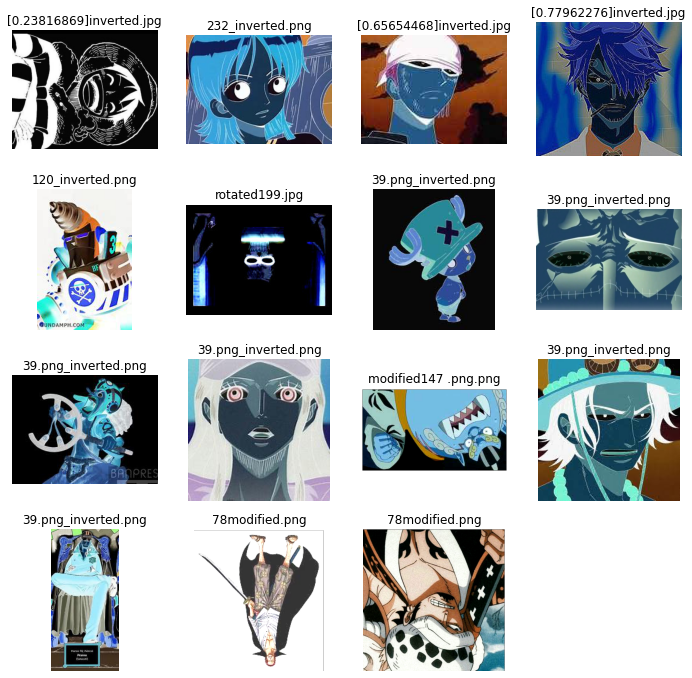

In [5]:
figure = plt.figure(figsize=(12,12))
columns = 4 
rows = int(len(samples)/columns +1)
count = 0 

for sample in samples: 
    with Image.open(sample) as image:
        plt.subplot(rows, columns, count+1)
        plt.title(os.path.basename(sample))
        plt.axis("off")
        plt.imshow(image)
        
        count+=1

# Model builder

## Some parameters 

In [6]:
import random

In [7]:
random.seed(123)
seed = random.randint(0,100)

In [8]:
batch_size = 32
width = 224
height = 224

## Training dataset definition

In [9]:
train_dataset = preprocessing.image_dataset_from_directory(
    directory=data_path,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(height,width),
    batch_size=batch_size
)

Found 9787 files belonging to 15 classes.
Using 7830 files for training.


2021-12-13 01:13:07.092309: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-13 01:13:07.095515: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-13 01:13:07.132524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 01:13:07.133193: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-12-13 01:13:07.133239: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-13 01:13:07.182777: I tensorflow/stream_executor/platform/def

In [10]:
classes_count = len(train_dataset.class_names)
class_names = train_dataset.class_names
print(class_names)

['Ace', 'Akainu', 'Brook', 'Chopper', 'Crocodile', 'Franky', 'Jinbei', 'Law', 'Luffy', 'Nami', 'Robin', 'Sanji', 'Shanks', 'Usopp', 'Zoro']


## Validation dataset definition

In [11]:
val_dataset = preprocessing.image_dataset_from_directory(
    directory=data_path,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(height, width),
    batch_size=batch_size
)

Found 9787 files belonging to 15 classes.
Using 1957 files for validation.


# Data augmentation

In [12]:
data_augmentation = Sequential(layers=[
                                tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(height,width,3)),
                                tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                                tf.keras.layers.experimental.preprocessing.RandomZoom(0.1), 
                    ], name="data_augmentation")

# Model builder

## Description

* A data augmentation layer which creates "modified" images of the training set
* A MobileNet layer which detects the features
* A Global average pooling layer which converts the feature vector into a 1280 element vector
* 1*3 Dense layers followed by a dropout layer
* An activation layer (sigmoid) which represents the final output: Probability of input(X) belonging to each class
* Output classes (probabilities) : ['Brook', 'Chopper', 'Franky', 'Jinbei', 'Luffy', 'Nami', 'Robin', 'Sanji', 'Usopp', 'Zoro']


In [13]:
def model_builder():

    model = Sequential()
    base_model = tf.keras.applications.MobileNet(input_shape=(width,height,3), weights="imagenet",include_top=False)

    model.add(data_augmentation)
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())  
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(units=1024, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=1024, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=512, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(classes_count, activation='sigmoid',name='final_output'))


    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Model fit

In [14]:
model = model_builder()

17227776/17225924 [==============================] - 0s 0us/step


### Use early stopping to stop the training process if the validation accuracy stops increasing after 6 epochs, and restore the weights which minimize the validation accuracy

In [15]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=15, mode ="max", verbose=2, restore_best_weights=True)

In [16]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=150,
    verbose=1, 
    callbacks = [stop_early]
)

Epoch 1/150


2021-12-13 01:13:14.196861: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-13 01:13:14.215921: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz
2021-12-13 01:13:14.763362: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-12-13 01:13:15.626887: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-12-13 01:13:18.266680: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


245/245 [==============================] - 154s 582ms/step - loss: 2.0067 - accuracy: 0.3857 - val_loss: 2.9080 - val_accuracy: 0.3015
Epoch 2/150
245/245 [==============================] - 93s 375ms/step - loss: 1.1626 - accuracy: 0.6602 - val_loss: 2.1556 - val_accuracy: 0.5273
Epoch 3/150
245/245 [==============================] - 93s 376ms/step - loss: 0.8988 - accuracy: 0.7399 - val_loss: 1.8710 - val_accuracy: 0.5524
Epoch 4/150
245/245 [==============================] - 94s 379ms/step - loss: 0.7692 - accuracy: 0.7878 - val_loss: 2.6145 - val_accuracy: 0.4630
Epoch 5/150
245/245 [==============================] - 94s 378ms/step - loss: 0.6626 - accuracy: 0.8092 - val_loss: 1.6981 - val_accuracy: 0.5841
Epoch 6/150
245/245 [==============================] - 93s 375ms/step - loss: 0.6523 - accuracy: 0.8204 - val_loss: 0.7145 - val_accuracy: 0.8125
Epoch 7/150
245/245 [==============================] - 93s 374ms/step - loss: 0.5454 - accuracy: 0.8451 - val_loss: 0.8103 - val_accura

# Plotting the training results

## MobileNet : Dropout = 0.2

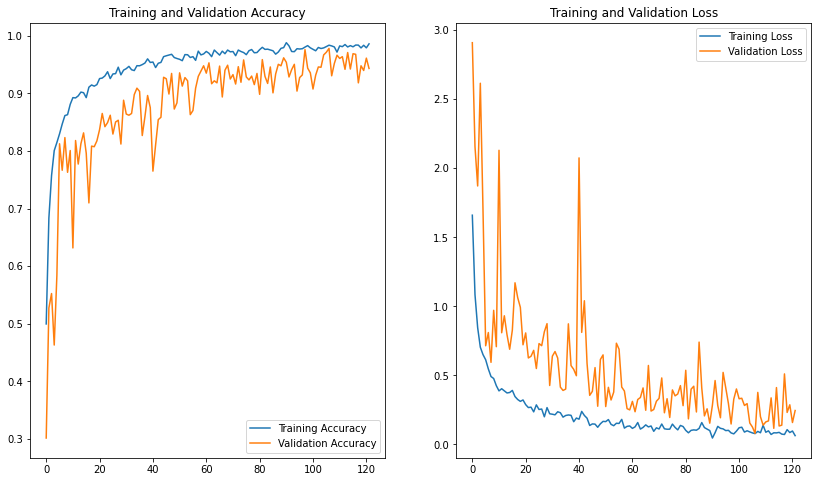

Maximum validation accuracy:  0.9780275821685791
Minimum loss: 0.08042208850383759


In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

position = np.argmax(history.history['val_accuracy'])
print(f"Maximum validation accuracy:  {history.history['val_accuracy'][position]}\nMinimum loss: {history.history['val_loss'][position]}")

# Model summary 

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1

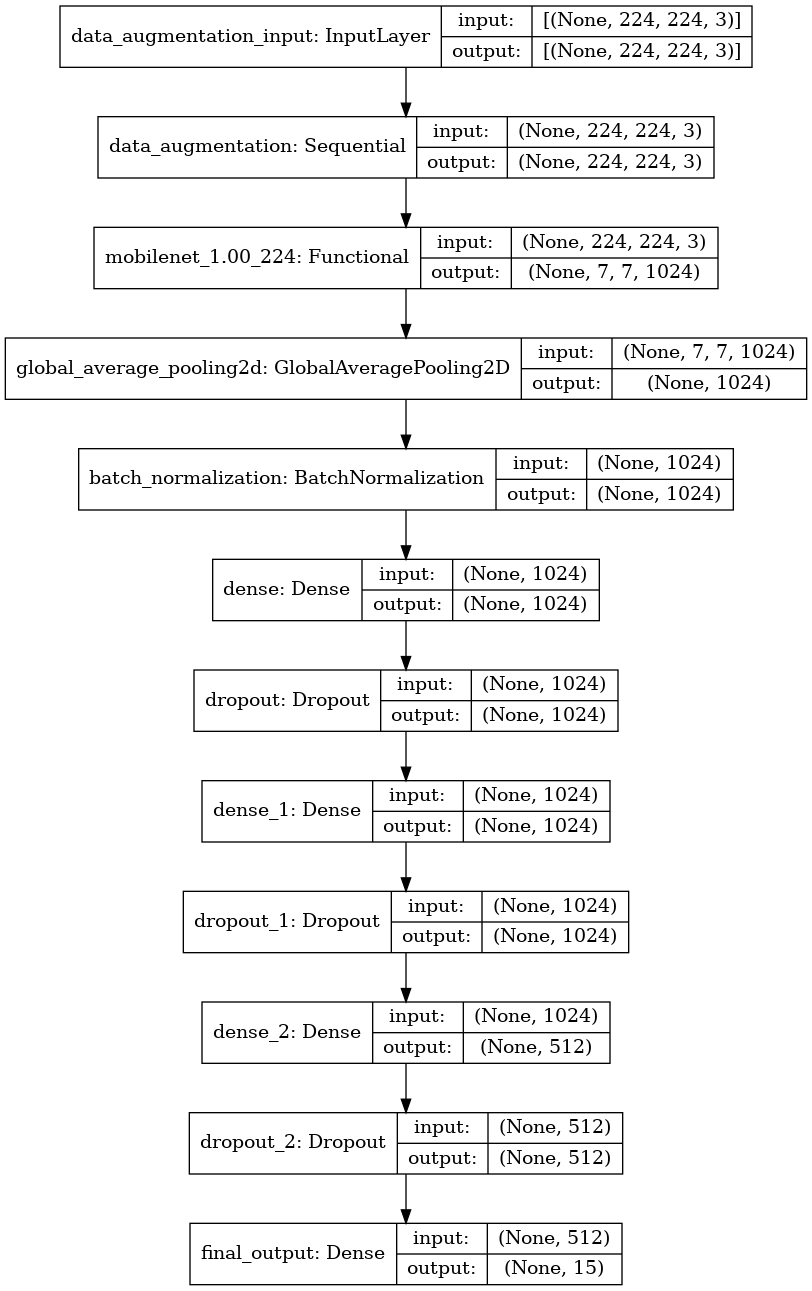

In [19]:
tf.keras.utils.plot_model(model,show_shapes=True)

# Evaluate the model 

In [20]:
model.evaluate(x=val_dataset, return_dict=True)

62/62 [==============================] - 13s 188ms/step - loss: 0.0804 - accuracy: 0.9780


{'loss': 0.08042208105325699, 'accuracy': 0.9780275821685791}

In [21]:
model.save("One_Piece_Image_Classifier_Model_v14")

2021-12-13 04:32:43.524023: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
